In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Add, Concatenate, Embedding, Flatten, Input, MultiHeadAttention
from tensorflow.keras.layers import Add, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from scipy.stats import spearmanr
import os

# Load data
os.chdir('../data/final/')
X_image = np.load('image_embeddings.npy')
X_text = np.load('text_embeddings.npy')
df = pd.read_csv('data_modeling_features_n_target.csv')

In [2]:
df.drop(columns=['image', 'Pid', 'Uid'], inplace=True)
df['Category'] = df['Category'].astype('str')
df['Subcategory'] = df['Subcategory'].astype('str')
df['Concept'] = df['Concept'].astype('category')
y = df['label'].values
numerical_features = ['ispro', 'canbuypro', 'photo_count', 'timezone_timezone_id', 'timezone_offset', 'year', 'month', 'day', 'hour', 'dayofweek']
X_numerical = df[numerical_features].values

# One-hot encoding for 'Category'
category_enc = OneHotEncoder(sparse=False)
X_category = category_enc.fit_transform(df[['Category']])

# Tokenizing 'SubCategory' and 'Concept'
tokenizer_subcat = Tokenizer()
tokenizer_subcat.fit_on_texts(df['Subcategory'])
X_subcategory = pad_sequences(tokenizer_subcat.texts_to_sequences(df['Subcategory']), maxlen=1)

tokenizer_concept = Tokenizer()
tokenizer_concept.fit_on_texts(df['Concept'].astype(str))
X_concept = pad_sequences(tokenizer_concept.texts_to_sequences(df['Concept'].astype(str)), maxlen=1)

subcategory_vocab_size = len(tokenizer_subcat.word_index) + 1
concept_vocab_size = len(tokenizer_concept.word_index) + 1
subcategory_embedding_dim = int(np.sqrt(subcategory_vocab_size))
concept_embedding_dim = int(np.sqrt(concept_vocab_size))

c:\Users\31405.ISBDOMAIN1\AppData\Local\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
input_img = Input(shape=(1000,), name='img_input')
input_text = Input(shape=(384,), name='text_input')
input_num = Input(shape=(X_numerical.shape[1],), name='num_input')
input_category = Input(shape=(X_category.shape[1],), name='category_input')
input_subcategory = Input(shape=(1,), name='subcategory_input')
input_concept = Input(shape=(1,), name='concept_input')

subcategory_embedding = Embedding(subcategory_vocab_size, subcategory_embedding_dim, input_length=1)(input_subcategory)
concept_embedding = Embedding(concept_vocab_size, concept_embedding_dim, input_length=1)(input_concept)

subcategory_flat = Flatten()(subcategory_embedding)
concept_flat = Flatten()(concept_embedding)

concatenated = Concatenate()([input_img, input_text, input_num, input_category, subcategory_flat, concept_flat])
# More complex dense layers
dense1 = Dense(512, activation='relu')(concatenated)
batch_norm1 = BatchNormalization()(dense1)
dropout1 = Dropout(0.5)(batch_norm1)

dense2 = Dense(256, activation='relu')(dropout1)
batch_norm2 = BatchNormalization()(dense2)
dropout2 = Dropout(0.4)(batch_norm2)

dense3 = Dense(128, activation='relu')(dropout2)
batch_norm3 = BatchNormalization()(dense3)
dropout3 = Dropout(0.3)(batch_norm3)

# Adding a residual connection
residual = Dense(128, activation='relu')(dropout1)  # This layer is connected from dropout1
residual_connection = Add()([dropout3, residual])

dense4 = Dense(64, activation='relu')(residual_connection)
batch_norm4 = BatchNormalization()(dense4)
output = Dense(1, activation='linear')(batch_norm4)

model = Model(inputs=[input_img, input_text, input_num, input_category, input_subcategory, input_concept], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [4]:
X_train_text, X_test_text, X_train_img, X_test_img, X_train_num, X_test_num, X_train_cat, X_test_cat, X_train_subcat, X_test_subcat, X_train_concept, X_test_concept, y_train, y_test = train_test_split(
    X_text, X_image, X_numerical, X_category, X_subcategory, X_concept, y, test_size=0.2, random_state=42
)

In [5]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [6]:
class SpearmanRankCorrelation(Callback):
    def __init__(self, train_data, validation_data):
        super(SpearmanRankCorrelation, self).__init__()
        self.train_data = train_data
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Calculate for training data
        X_train = [self.train_data[0][0], self.train_data[0][1], self.train_data[0][2], self.train_data[0][3], self.train_data[0][4], self.train_data[0][5]]
        y_train = self.train_data[1]
        y_train_pred = self.model.predict(X_train)
        train_rho, _ = spearmanr(y_train, y_train_pred[:, 0])
        logs['train_spearman_corr'] = train_rho

        # Calculate for validation data
        X_val = [self.validation_data[0][0], self.validation_data[0][1], self.validation_data[0][2], self.validation_data[0][3], self.validation_data[0][4], self.validation_data[0][5]]
        y_val = self.validation_data[1]
        y_val_pred = self.model.predict(X_val)
        val_rho, _ = spearmanr(y_val, y_val_pred[:, 0])
        logs['val_spearman_corr'] = val_rho

        print(f'Epoch {epoch + 1}: Train Spearman Rank Correlation: {train_rho:.4f}, Val Spearman Rank Correlation: {val_rho:.4f}')



early_stopping = EarlyStopping(monitor='val_mae', patience=11, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_mae', save_best_only=True, verbose=1)
spearman_callback = SpearmanRankCorrelation(
    train_data=([X_train_img, X_train_text, X_train_num, X_train_cat, X_train_subcat, X_train_concept], y_train),
    validation_data=([X_test_img, X_test_text, X_test_num, X_test_cat, X_test_subcat, X_test_concept], y_test)
)
callbacks = [early_stopping, model_checkpoint, spearman_callback, reduce_lr]

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 subcategory_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 concept_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 8)                 632       ['subcategory_input[0][0]']   
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 25)                16725     ['concept_input[0][0]']   

In [8]:
history1= model.fit([X_train_img, X_train_text, X_train_num, X_train_cat, X_train_subcat, X_train_concept], y_train, 
          validation_data=([X_test_img, X_test_text, X_test_num, X_test_cat, X_test_subcat, X_test_concept], y_test),
          epochs=100,  # Adjust as needed
          batch_size=512,
          callbacks=callbacks)

Epoch 1/100


392/393 [============================>.] - ETA: 0s - loss: 16.8590 - mae: 3.2020
Epoch 1: val_mae improved from inf to 10.51581, saving model to best_model.h5


c:\Users\31405.ISBDOMAIN1\AppData\Local\miniconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1571/1571 [==============================] - 3s 2ms/step
Epoch 1: Train Spearman Rank Correlation: 0.4823, Val Spearman Rank Correlation: 0.4760
393/393 [==============================] - 31s 72ms/step - loss: 16.8375 - mae: 3.1993 - val_loss: 115.2324 - val_mae: 10.5158 - train_spearman_corr: 0.4823 - val_spearman_corr: 0.4760 - lr: 0.0010
Epoch 2/100
391/393 [============================>.] - ETA: 0s - loss: 4.0989 - mae: 1.5611
Epoch 2: val_mae improved from 10.51581 to 4.17319, saving model to best_model.h5
1571/1571 [==============================] - 3s 2ms/step
Epoch 2: Train Spearman Rank Correlation: 0.5582, Val Spearman Rank Correlation: 0.5512
393/393 [==============================] - 28s 71ms/step - loss: 4.0985 - mae: 1.5610 - val_loss: 21.4060 - val_mae: 4.1732 - train_spearman_corr: 0.5582 - val_spearman_corr: 0.5512 - lr: 0.0010
Epoch 3/100
391/393 [============================>.] - ETA: 0s - loss: 3.8454 - mae: 1.5065
Epoch 3: val_mae did not improve from 4.17319
1571/

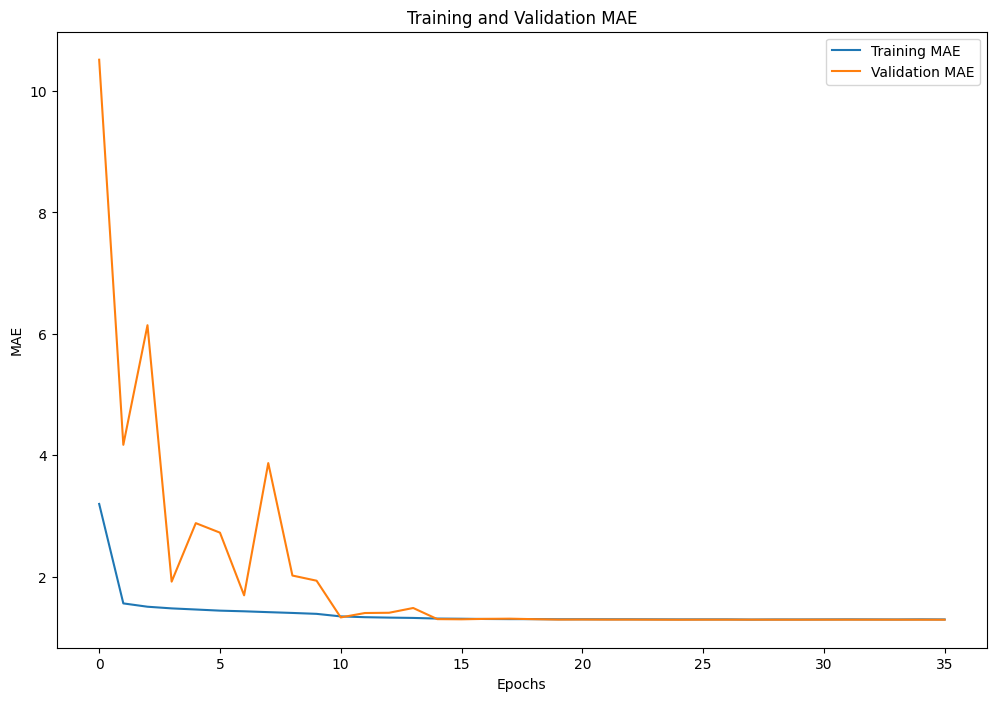

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history1.history['mae'], label='Training MAE')
plt.plot(history1.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

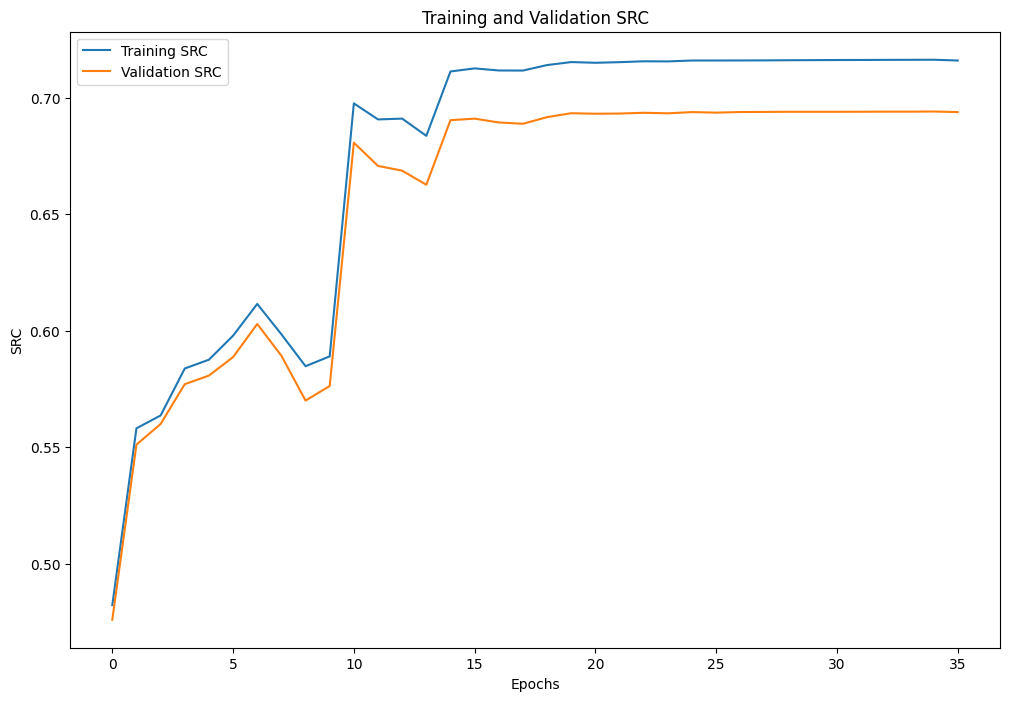

In [10]:
# Plot SRC
plt.figure(figsize=(12, 8))
plt.plot(history1.history['train_spearman_corr'], label='Training SRC')
plt.plot(history1.history['val_spearman_corr'], label='Validation SRC')
plt.title('Training and Validation SRC')
plt.ylabel('SRC')
plt.xlabel('Epochs')
plt.legend()